### Getting data into the notebook

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
raw_import = pd.read_csv('/Users/pang/repos/stack-overflow-survey/_data/developer_survey_2019/survey_results_public.csv', \
                         index_col='Respondent')

# start with 88883 rows

### Early culling of data and features

Because this effort is trying to determine if an employed developer will is unsatisfied with their current job, we will filter out respondents who did not report themselves an a professional developer and not employed full-time. This reduced our data set from 

In [3]:
# filter for employed developers with an answer for the column in question (JobSat)

int_df = raw_import[(raw_import['MainBranch']=='I am a developer by profession') & \
                  (raw_import['Employment']=='Employed full-time')]
int_df = int_df.drop(columns=['MainBranch', 'Employment'])
int_df = int_df[int_df['JobSat'].notnull()]

# 55166 rows left

In [4]:
# drop all supporting compensation data and only keep the yearly compensation converte to USD 
# (using the exchange rate on 2019-02-01, assuming 12 working months and 50 working weeks")

int_df = int_df.drop(columns=['CurrencySymbol', 'CurrencyDesc', 'CompTotal', 'CompFreq'])

### Set up target feature

Create a new dataframe to run analysis on. We start with JobSat, which is our target. Values are updated so that 1=satisfied and 0=not satisfied.

In [5]:
df = pd.DataFrame(int_df['JobSat'])

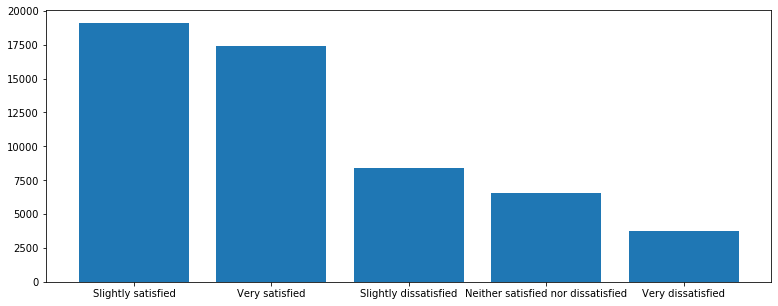

In [6]:
counts = dict(df['JobSat'].value_counts())
label = []
values = []
for k in counts.keys():
    label.append(k)
    values.append(counts[k])

plt.figure(figsize=(13,5))
plt.bar(label, values);

To separate out to two classifications, we'll set those who marked themselves as "Very satisfied" and "Slightly satisfied" as 1 and the rest as 0.

In [7]:
df = df.replace(to_replace=['Very satisfied', 
                            'Slightly satisfied'], value=1)
df = df.replace(to_replace=['Slightly dissatisfied', 
                            'Very dissatisfied', 
                            'Neither satisfied nor dissatisfied'], value=0)

### Set up baseline

In [8]:
print(f'The baseline approach is to predict employee is satisfied {(df["JobSat"].sum() / 55166) * 100:.2f}% of the time')

The baseline approach is to predict employee is satisfied 66.16% of the time


### Add a few features

Namely...
* Hobbyist: Do you code as a hobby?
* OpenSourcer: How often do you contribute to open source?
* LastHireDate: When was the last time that you took a job with a new employer?
* SOVisitFreq: How frequently would you say you visit Stack Overflow?
* YearsCode: Including any education, how many years have you been coding?

The following features has around 200 null records which is around 0.3% of the the full dataset I intend to analyse. I will fill with the mean for now:
* LastHireDate
* SOVisitFreq
* YearsCode 

In [9]:
df['Hobbyist'] = int_df['Hobbyist'].replace('Yes',1).replace('No',0)

In [10]:
df['OpenSourcer'] = int_df['OpenSourcer'].replace('Never',0)\
    .replace('Less than once per year',1)\
    .replace('Less than once a month but more than once per year',4)\
    .replace('Once a month or more often',13)

In [11]:
df['LastHireDate'] = int_df['LastHireDate'].replace('Less than a year ago',0)\
    .replace('1-2 years ago',1)\
    .replace('More than 4 years ago',5)\
    .replace('3-4 years ago',3)\
    .replace('NA - I am an independent contractor or self employed',0)\
    .replace("I've never had a job",0)
df['LastHireDate'] = df['LastHireDate'].fillna(df['LastHireDate'].mean())

In [12]:
df['SOVisitFreq'] = int_df['SOVisitFreq'].replace('Multiple times per day',1000)\
    .replace('Daily or almost daily',365)\
    .replace('A few times per week',100)\
    .replace('A few times per month or weekly',30)\
    .replace('Less than once per month or monthly',12)\
    .replace('I have never visited Stack Overflow (before today)', 0)
df['SOVisitFreq'] = df['SOVisitFreq'].fillna(df['SOVisitFreq'].mean())

In [13]:
df['YearsCode'] = int_df['YearsCode'].replace('Less than 1 year',0)\
    .replace('More than 50 years',52)
df['YearsCode'] = df['YearsCode'].fillna(df['YearsCode'].dropna().astype('int64').mean())
df['YearsCode'] = df['YearsCode'].astype('int64')

### Splitting set

In [14]:
# Evaluating models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score

# Classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [15]:
y = df['JobSat']
X = df.drop(columns='JobSat')

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=4444)

### See what fits on the models

In [17]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

lr = LogisticRegression(solver= 'liblinear')
lr.fit(X_train, y_train)

gnb = GaussianNB()
gnb.fit(X_train, y_train)

svc = SVC(gamma='scale')
svc.fit(X_train, y_train)

rfc = RandomForestClassifier(n_estimators=10)
rfc.fit(X_train, y_train)

dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [18]:
classifier_scores = {}

for name, classifier in [('K Nearest Neighbor', knn), 
                         ('Logistic Regression',lr), 
                         ('Gaussian Naive Bayes',gnb), 
                         ('Support Vector Machine',svc), 
                         ('Decision Tree',dtc), 
                         ('Random Forest',rfc)]:
    accuracy = cross_val_score(classifier, X_train, y_train, cv=5, scoring='accuracy')
    precision = precision_score(y_train,classifier.predict(X_train))
    recall = recall_score(y_train,classifier.predict(X_train))
    f1 = f1_score(y_train,classifier.predict(X_train))
    
    classifier_scores[name] = {
        'Accuracy' : accuracy.mean(),
        'Precision' : precision,
        'Recall' : recall,
        'F1' : f1
    }

scores = pd.DataFrame(classifier_scores)
scores

,K Nearest Neighbor,Logistic Regression,Gaussian Naive Bayes,Support Vector Machine,Decision Tree,Random Forest
Accuracy,0.595220,0.661384,0.661384,0.661384,0.610965,0.619717
Precision,0.694881,0.661384,0.661384,0.661384,0.704984,0.698451
Recall,0.819655,1.000000,1.000000,1.000000,0.923297,0.937549
F1,0.752129,0.796184,0.796184,0.796184,0.799505,0.800528


For our business problem, recall is more important that precision. The assumption is that intervening on an employee that is happy will do no harm and that intervening on an employee that is unhappy will help the company retain that employee.

Of the models, Logistic Regression, Gausian Naive Bayes, and Support Vector Machine are looking the best (however, the accuracy is not better than chance which is 0.6616). In the next notebook, we will add more features and tune the three remaining candidates to determine if we can do better than the baselines above.